## Install libraries

In [1]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install gym
!pip install wandb
!pip install gym pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [2]:
%%capture
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra]

## Import useful libraries

In [3]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)
import glob
import io
import os
import cv2
import base64
from collections import deque
from datetime import datetime
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb
import time

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Car Racing from github official site

In [4]:
import sys, math
import numpy as np

import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.envs.box2d.car_dynamics import Car
from gym.utils import colorize, seeding, EzPickle

import pyglet
from pyglet import gl

# Easiest continuous control task to learn from pixels, a top-down racing environment.
# Discrete control is reasonable in this environment as well, on/off discretization is
# fine.
#
# State consists of STATE_W x STATE_H pixels.
#
# Reward is -0.1 every frame and +1000/N for every track tile visited, where N is
# the total number of tiles visited in the track. For example, if you have finished in 732 frames,
# your reward is 1000 - 0.1*732 = 926.8 points.
#
# Game is solved when agent consistently gets 900+ points. Track generated is random every episode.
#
# Episode finishes when all tiles are visited. Car also can go outside of PLAYFIELD, that
# is far off the track, then it will get -100 and die.
#
# Some indicators shown at the bottom of the window and the state RGB buffer. From
# left to right: true speed, four ABS sensors, steering wheel position and gyroscope.
#
# To play yourself (it's rather fast for humans), type:
#
# python gym/envs/box2d/car_racing.py
#
# Remember it's powerful rear-wheel drive car, don't press accelerator and turn at the
# same time.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

STATE_W = 96   # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE       = 6.0        # Track scale
TRACK_RAD   = 900/SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD   = 2000/SCALE # Game over boundary
FPS         = 50         # Frames per second
ZOOM        = 2.7        # Camera zoom
ZOOM_FOLLOW = True       # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21/SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40/SCALE
BORDER = 8/SCALE
BORDER_MIN_COUNT = 4

ROAD_COLOR = [0.4, 0.4, 0.4]

class FrictionDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        self._contact(contact, True)
    def EndContact(self, contact):
        self._contact(contact, False)
    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj  = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj  = u1
        if not tile:
            return

        tile.color[0] = ROAD_COLOR[0]
        tile.color[1] = ROAD_COLOR[1]
        tile.color[2] = ROAD_COLOR[2]
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            # print tile.road_friction, "ADD", len(obj.tiles)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0/len(self.env.track)
                self.env.tile_visited_count += 1
        else:
            obj.tiles.remove(tile)
            # print tile.road_friction, "DEL", len(obj.tiles) -- should delete to zero when on grass (this works)

class CarRacing(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array', 'state_pixels'],
        'video.frames_per_second' : FPS
    }

    def __init__(self, totoal_episode_steps=1000 ,verbose=1):
        EzPickle.__init__(self)
        self.seed()
        self.contactListener_keepref = FrictionDetector(self)
        self.world = Box2D.b2World((0,0), contactListener=self.contactListener_keepref)
        self.viewer = None
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.fd_tile = fixtureDef(
                shape = polygonShape(vertices=
                    [(0, 0),(1, 0),(1, -1),(0, -1)]))

        # discrete car racer
        # self.action_space = spaces.Box( np.array([-1,0,0]), np.array([+1,+1,+1]), dtype=np.float32)  # steer, gas, brake
        self.action_space = spaces.Discrete(5)
        self.actions = [np.array([-1,0,0], dtype=np.float32), 
                        np.array([1,0,0], dtype=np.float32), 
                        np.array([0,1,0], dtype=np.float32), 
                        np.array([0,0,0.8], dtype=np.float32), 
                        np.array([0,0,0], dtype=np.float32)]  # left right, gas, brake, nothing
        self.totoal_episode_steps = totoal_episode_steps
        self.current_steps = 0

        self.observation_space = spaces.Box(low=0, high=255, shape=(96, 96, 3), dtype=np.uint8)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        self.car.destroy()

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            alpha = 2*math.pi*c/CHECKPOINTS + self.np_random.uniform(0, 2*math.pi*1/CHECKPOINTS)
            rad = self.np_random.uniform(TRACK_RAD/3, TRACK_RAD)
            if c==0:
                alpha = 0
                rad = 1.5*TRACK_RAD
            if c==CHECKPOINTS-1:
                alpha = 2*math.pi*c/CHECKPOINTS
                self.start_alpha = 2*math.pi*(-0.5)/CHECKPOINTS
                rad = 1.5*TRACK_RAD
            checkpoints.append( (alpha, rad*math.cos(alpha), rad*math.sin(alpha)) )

        # print "\n".join(str(h) for h in checkpoints)
        # self.road_poly = [ (    # uncomment this to see checkpoints
        #    [ (tx,ty) for a,tx,ty in checkpoints ],
        #    (0.7,0.7,0.9) ) ]
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5*TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2*math.pi
            while True: # Find destination from checkpoints
                failed = True
                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break
                if not failed:
                    break
                alpha -= 2*math.pi
                continue
            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            proj = r1x*dest_dx + r1y*dest_dy  # destination vector projected on rad
            while beta - alpha >  1.5*math.pi:
                 beta -= 2*math.pi
            while beta - alpha < -1.5*math.pi:
                 beta += 2*math.pi
            prev_beta = beta
            proj *= SCALE
            if proj >  0.3:
                 beta -= min(TRACK_TURN_RATE, abs(0.001*proj))
            if proj < -0.3:
                 beta += min(TRACK_TURN_RATE, abs(0.001*proj))
            x += p1x*TRACK_DETAIL_STEP
            y += p1y*TRACK_DETAIL_STEP
            track.append( (alpha,prev_beta*0.5 + beta*0.5,x,y) )
            if laps > 4:
                 break
            no_freeze -= 1
            if no_freeze==0:
                 break
        # print "\n".join([str(t) for t in enumerate(track)])

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i==0:
                return False  # Failed
            pass_through_start = track[i][0] > self.start_alpha and track[i-1][0] <= self.start_alpha
            if pass_through_start and i2==-1:
                i2 = i
            elif pass_through_start and i1==-1:
                i1 = i
                break
        if self.verbose == 1:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2-i1))
        assert i1!=-1
        assert i2!=-1

        track = track[i1:i2-1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square( first_perp_x*(track[0][2] - track[-1][2]) ) +
            np.square( first_perp_y*(track[0][3] - track[-1][3]) ))
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False]*len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i-neg-0][1]
                beta2 = track[i-neg-1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE*0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i-neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i-1]
            road1_l = (x1 - TRACK_WIDTH*math.cos(beta1), y1 - TRACK_WIDTH*math.sin(beta1))
            road1_r = (x1 + TRACK_WIDTH*math.cos(beta1), y1 + TRACK_WIDTH*math.sin(beta1))
            road2_l = (x2 - TRACK_WIDTH*math.cos(beta2), y2 - TRACK_WIDTH*math.sin(beta2))
            road2_r = (x2 + TRACK_WIDTH*math.cos(beta2), y2 + TRACK_WIDTH*math.sin(beta2))
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01*(i%3)
            t.color = [ROAD_COLOR[0] + c, ROAD_COLOR[1] + c, ROAD_COLOR[2] + c]
            t.road_visited = False
            t.road_friction = 1.0
            t.fixtures[0].sensor = True
            self.road_poly.append(( [road1_l, road1_r, road2_r, road2_l], t.color ))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (x1 + side* TRACK_WIDTH        *math.cos(beta1), y1 + side* TRACK_WIDTH        *math.sin(beta1))
                b1_r = (x1 + side*(TRACK_WIDTH+BORDER)*math.cos(beta1), y1 + side*(TRACK_WIDTH+BORDER)*math.sin(beta1))
                b2_l = (x2 + side* TRACK_WIDTH        *math.cos(beta2), y2 + side* TRACK_WIDTH        *math.sin(beta2))
                b2_r = (x2 + side*(TRACK_WIDTH+BORDER)*math.cos(beta2), y2 + side*(TRACK_WIDTH+BORDER)*math.sin(beta2))
                self.road_poly.append(( [b1_l, b1_r, b2_r, b2_l], (1,1,1) if i%2==0 else (1,0,0) ))
        self.track = track
        return True

    def reset(self):
        self.current_steps = 0

        self._destroy()
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.road_poly = []

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose == 1:
                print("retry to generate track (normal if there are not many of this messages)")
        self.car = Car(self.world, *self.track[0][1:4])

        return self.step(None)[0]

    def step(self, action):
        self.current_steps += 1
        # car racer discrete
        if action is not None:
            action = self.actions[action]
            self.car.steer(-action[0])
            self.car.gas(action[1])
            self.car.brake(action[2])

        self.car.step(1.0/FPS)
        self.world.Step(1.0/FPS, 6*30, 2*30)
        self.t += 1.0/FPS

        self.state = self.render("state_pixels")

        step_reward = 0
        done = False
        if action is not None: # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count==len(self.track):
                done = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                done = True
                step_reward = -100
            if self.current_steps > self.totoal_episode_steps:
                done = True
        
        if self.current_steps > self.totoal_episode_steps:
            done = True 

        return self.state, step_reward, done, {}

    def render(self, mode='human'):
        assert mode in ['human', 'state_pixels', 'rgb_array']
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(WINDOW_W, WINDOW_H)
            self.score_label = pyglet.text.Label('0000', font_size=36,
                x=20, y=WINDOW_H*2.5/40.00, anchor_x='left', anchor_y='center',
                color=(255,255,255,255))
            self.transform = rendering.Transform()

        if "t" not in self.__dict__: return  # reset() not called yet

        zoom = 0.1*SCALE*max(1-self.t, 0) + ZOOM*SCALE*min(self.t, 1)   # Animate zoom first second
        zoom = 0.1*SCALE*0 + ZOOM*SCALE*1   # Animate zoom first second
        zoom_state  = ZOOM*SCALE*STATE_W/WINDOW_W
        zoom_video  = ZOOM*SCALE*VIDEO_W/WINDOW_W
        scroll_x = self.car.hull.position[0]
        scroll_y = self.car.hull.position[1]
        angle = -self.car.hull.angle
        vel = self.car.hull.linearVelocity
        if np.linalg.norm(vel) > 0.5:
            angle = math.atan2(vel[0], vel[1])
        self.transform.set_scale(zoom, zoom)
        self.transform.set_translation(
            WINDOW_W/2 - (scroll_x*zoom*math.cos(angle) - scroll_y*zoom*math.sin(angle)),
            WINDOW_H/4 - (scroll_x*zoom*math.sin(angle) + scroll_y*zoom*math.cos(angle)) )
        self.transform.set_rotation(angle)

        self.car.draw(self.viewer, mode!="state_pixels")

        arr = None
        win = self.viewer.window
        win.switch_to()
        win.dispatch_events()

        win.clear()
        t = self.transform
        if mode=='rgb_array':
            VP_W = VIDEO_W
            VP_H = VIDEO_H
        elif mode == 'state_pixels':
            VP_W = STATE_W
            VP_H = STATE_H
        else:
            pixel_scale = 1
            if hasattr(win.context, '_nscontext'):
                pixel_scale = win.context._nscontext.view().backingScaleFactor()  # pylint: disable=protected-access
            VP_W = int(pixel_scale * WINDOW_W)
            VP_H = int(pixel_scale * WINDOW_H)

        gl.glViewport(0, 0, VP_W, VP_H)
        t.enable()
        self.render_road()
        for geom in self.viewer.onetime_geoms:
            geom.render()
        self.viewer.onetime_geoms = []
        t.disable()
        self.render_indicators(WINDOW_W, WINDOW_H)

        if mode == 'human':
            win.flip()
            return self.viewer.isopen

        image_data = pyglet.image.get_buffer_manager().get_color_buffer().get_image_data()
        arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')
        arr = arr.reshape(VP_H, VP_W, 4)
        arr = arr[::-1, :, 0:3]

        return arr

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def render_road(self):
        gl.glBegin(gl.GL_QUADS)
        gl.glColor4f(0.4, 0.8, 0.4, 1.0)
        gl.glVertex3f(-PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, -PLAYFIELD, 0)
        gl.glVertex3f(-PLAYFIELD, -PLAYFIELD, 0)
        gl.glColor4f(0.4, 0.9, 0.4, 1.0)
        k = PLAYFIELD/20.0
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                gl.glVertex3f(k*x + k, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + k, 0)
                gl.glVertex3f(k*x + k, k*y + k, 0)
        for poly, color in self.road_poly:
            gl.glColor4f(color[0], color[1], color[2], 1)
            for p in poly:
                gl.glVertex3f(p[0], p[1], 0)
        gl.glEnd()

    def render_indicators(self, W, H):
        gl.glBegin(gl.GL_QUADS)
        s = W/40.0
        h = H/40.0
        gl.glColor4f(0,0,0,1)
        gl.glVertex3f(W, 0, 0)
        gl.glVertex3f(W, 5*h, 0)
        gl.glVertex3f(0, 5*h, 0)
        gl.glVertex3f(0, 0, 0)
        def vertical_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h, 0)
            gl.glVertex3f((place+0)*s, h, 0)
        def horiz_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, 4*h , 0)
            gl.glVertex3f((place+val)*s, 4*h, 0)
            gl.glVertex3f((place+val)*s, 2*h, 0)
            gl.glVertex3f((place+0)*s, 2*h, 0)
        true_speed = np.sqrt(np.square(self.car.hull.linearVelocity[0]) + np.square(self.car.hull.linearVelocity[1]))
        vertical_ind(5, 0.02*true_speed, (1,1,1))
        vertical_ind(7, 0.01*self.car.wheels[0].omega, (0.0,0,1)) # ABS sensors
        vertical_ind(8, 0.01*self.car.wheels[1].omega, (0.0,0,1))
        vertical_ind(9, 0.01*self.car.wheels[2].omega, (0.2,0,1))
        vertical_ind(10,0.01*self.car.wheels[3].omega, (0.2,0,1))
        horiz_ind(20, -10.0*self.car.wheels[0].joint.angle, (0,1,0))
        horiz_ind(30, -0.8*self.car.hull.angularVelocity, (1,0,0))
        gl.glEnd()
        self.score_label.text = "%04i" % self.reward
        self.score_label.draw()

def state_image_preprocess(state_image):
    # crop image
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)

## Quick example with CarRacing

Track generation: 1180..1479 -> 299-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:427: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


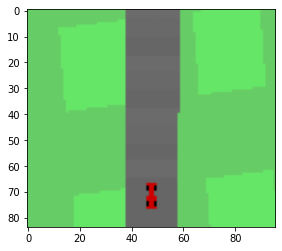

In [5]:
# from gym.envs.box2d import CarRacing
env = gnwrapper.Animation(CarRacing())
env = CarRacing()

env.reset()
env.render()
im = env.render("state_pixels")

def state_image_preprocess(state_image):
    # crop image
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)

# plt.imshow(im)
state_image_preprocess(im).shape
plt.imshow(state_image_preprocess(im).cpu().squeeze(0).permute(1, 2, 0).numpy())

## Custom Callback Class

In [6]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        self.episodes = 0

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        # at the end of every episode
        if self.locals["done"][0]:
            # if log interval has passed
            if self.episodes % self.locals["log_interval"] == 0:
                # log at wandb and print the last video
                # Save your model and optimizer
                self.model.save(MODEL_SAVE_NAME)
                # Save as artifact for version control.
                artifact = wandb.Artifact(MODEL_SAVE_NAME, type='model')
                artifact.add_file(MODEL_SAVE_NAME+".zip")
                wandb.log_artifact(artifact)


                mp4list = glob.glob('video/*.mp4')
                print(mp4list)
                if len(mp4list) > 0:
                    print(len(mp4list))
                    mp4 = mp4list[-1]
                    video = io.open(mp4, 'r+b').read()
                    encoded = base64.b64encode(video)

                    # log gameplay video in wandb
                    wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

                    # display gameplay video
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                                loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                            </video>'''.format(encoded.decode('ascii'))))
                    print("Episode ", self.episodes)
            self.episodes += 1

        
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

## Training

In [9]:
from stable_baselines3 import DQN
from stable_baselines3.dqn import CnnPolicy

DEBUG               = False
NUM_OF_STEPS        = 1000
NUM_OF_EPISODES     = 5
LOG_INTERVAL        = 2
BUFFER_SIZE         = 10000
LEARNING_STARTS     = 1000
WANDB_ID            = "spympr99"
WNDB_NAME           = "SPYROS"
LOAD_SAVED_MODEL    = False
MODEL_SAVE_NAME     = "DQN_RL_TEST"
SAVED_MODEL_VERSION = "latest"

# wnadb api key: 00d5bfbd342bb73d5aaf4f2833436d20457ef040
os.environ["WANDB_ENTITY"]  = "andreas_giannoutsos"
os.environ["WANDB_PROJECT"] = "gym_car_racer"
os.environ["WANDB_RESUME"]  = "allow"
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# env = CarRacing(NUM_OF_STEPS)
env = gym.wrappers.Monitor(CarRacing(NUM_OF_STEPS), './video', force=True)

# Load model
if LOAD_SAVED_MODEL:
    try:
        model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':'+SAVED_MODEL_VERSION, type='model')
        artifact_dir = model_artifact.download()
        model = DQN.load(artifact_dir+"/"+MODEL_SAVE_NAME, env=env)
    except:
        print("no model found")
else:    
    model = DQN(CnnPolicy, env, verbose=1, buffer_size=LOG_INTERVAL, learning_starts=LEARNING_STARTS)

# Train model
model.learn(total_timesteps=NUM_OF_STEPS*NUM_OF_EPISODES, log_interval=LOG_INTERVAL, callback=CustomCallback())

Episode  6
